# Geometry operations 

## 准备工作

In [2]:
#| echo: false
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.max_rows = 6
pd.options.display.max_columns = 6
pd.options.display.max_colwidth = 35
plt.rcParams["figure.figsize"] = (5, 5)

In [3]:
import numpy as np
import shapely.geometry
import geopandas as gpd
import topojson as tp
import rasterio
import rasterio.warp
import rasterio.plot

In [4]:
seine = gpd.read_file("data/seine.gpkg")
us_states = gpd.read_file("data/us_states.gpkg")
nz = gpd.read_file("data/nz.gpkg")

## 介绍

到目前为止，本书已经解释了地理数据集的结构（第 2 章），以及如何根据其非地理属性（第 3 章）和空间关系（第 4 章）来操作它们。 本章重点介绍如何操作地理对象的地理元素，例如简化和转换矢量几何、裁剪栅格数据集以及将矢量对象转换为栅格以及将栅格转换为矢量。 阅读完它并尝试最后的练习后，您应该理解并控制 sf 对象中的几何列以及栅格中表示的像素相对于其他地理对象的范围和地理位置。

@sec-geo-vec 涵盖了使用“一元”和“二元”运算转换矢量几何形状。 一元运算独立地作用于单个几何体，包括简化（线和多边形）、创建缓冲区和质心以及使用“仿射变换”（@sec-simplification 到 @sec-affine-）移动/缩放/旋转单个几何体。 变换）。 二元变换根据一个几何体的形状修改另一个几何体，包括剪切和几何联合，分别在@sec-clipping和@sec-geometry-unions中介绍。 类型转换（例如，从多边形到直线）在@sec-type-transformations 节中进行了演示。

@sec-geo-ras 涵盖了栅格对象的几何变换。 这涉及更改底层像素的大小和数量，并为它们分配新值。 它教授如何更改分辨率（也称为栅格聚合和分解）、栅格的范围和起源。 如果想要对齐不同来源的栅格数据集，这些操作尤其有用。 对齐的栅格对象在像素之间共享一对一的对应关系，允许使用地图代数运算来处理它们，如第 4.3.2 节中所述。 最后的第 6 节连接矢量和光栅对象。 它展示了如何通过矢量几何“屏蔽”和“提取”栅格值。 重要的是，它展示了如何“多边形化”栅格和“栅格化”矢量数据集，使这两种数据模型更具互换性。

## 矢量数据的几何运算

本节介绍以某种方式改变矢量图层几何形状的操作。 它比上一章（@sec-spatial-vec）中介绍的空间数据操作更高级，因为在这里我们深入研究几何：本节中讨论的函数适用于几何（`GeoSeries`）部分， 作为独立对象或作为“GeoDataFrame”的一部分。

### 简化

简化是矢量对象（线和多边形）的概括过程，通常用于较小比例的地图。 简化对象的另一个原因是减少它们消耗的内存、磁盘空间和网络带宽：在将复杂的几何图形发布为交互式地图之前简化它们可能是明智的做法。 `geopandas` 包提供了 `.simplify` 方法，该方法使用 Douglas-Peucker 算法的 GEOS 实现来减少顶点数。 `.simplify` 使用 `tolerance` 来控制地图单位的泛化程度（详细信息请参见 Douglas and Peucker 1973）。

例如，可以使用以下命令创建“LineString”几何图形的简化几何图形，表示塞纳河及其支流，使用“2000”米的容差：

In [5]:
seine_simp = seine.simplify(2000)  # 2000 m

图 @fig-simplify-lines 说明了输入和简化的结果：

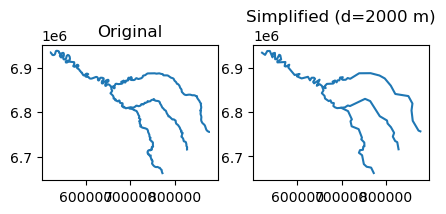

In [6]:
#| label: fig-simplify-lines
#| fig-cap: Comparison of the original and simplified geometry of the seine object. 

fig, axes = plt.subplots(ncols=2)
seine.plot(ax=axes[0])
seine_simp.plot(ax=axes[1])
axes[0].set_title('Original')
axes[1].set_title('Simplified (d=2000 m)');

生成的“seine_simp”对象是原始“seine”的副本，但顶点较少。 这是显而易见的，结果在视觉上更简单（@fig-simplify-lines，右）并且比原始对象消耗更少的内存，如下所示：

In [7]:
import sys
sys.getsizeof(seine)       ## Original (bytes)

354

In [8]:
sys.getsizeof(seine_simp)  ## Simplified (bytes)

168

简化也适用于多边形。 这是使用“us_states”来说明的，代表邻近的美国。 正如我们在 @sec-reproj-geo-data 中所示，GEOS 假设数据位于预计的 CRS 中，这在使用地理 CRS 时可能会导致意外结果。 因此，第一步是将数据投影到一些适当的投影 CRS 中，例如美国国家地图集等面积 (epsg = `2163`)（图 @fig-simplify-polygons 的左侧）：

In [9]:
us_states2163 = us_states.to_crs(2163)

`geopandas` 中的 `.simplify` 方法与 `"Polygon"`/`"MultiPolygon"` 层（例如 `us_states2163`）的工作方式相同：

In [10]:
us_states_simp1 = us_states2163.simplify(100000)

`.simplify` 的一个限制是它在每个几何体的基础上简化对象。 这意味着“拓扑”丢失，导致重叠和“多孔”区域单元，如图@fig-simplify-polygons（中面板）所示。 “topojson”中的“toposimplify”函数提供了解决此问题的替代方案。 默认情况下，它使用 Douglas-Peucker 算法，如“.simplify”方法。 另一种算法称为 Visvalingam-Whyatt，它克服了 Douglas-Peucker 算法的一些限制（Visvalingam 和 Whyatt 1993），也可在“toposimplify”中使用。 然而，“toposimplify”的主要优点是它具有拓扑“意识”。 也就是说，它简化了多边形的组合边界（而不是每个多边形本身），从而确保保持重叠。 以下代码块使用此函数来简化“us_states2163”：

In [11]:
topo = tp.Topology(us_states2163, prequantize=False)
us_states_simp2 = topo.toposimplify(100000).to_gdf()

d:\work\miniconda3\envs\topojson\lib\site-packages\topojson\core\dedup.py:107: RuntimeWarning: invalid value encountered in cast
  data["bookkeeping_shared_arcs"] = array_bk_sarcs.astype(np.int64).tolist()


图 @fig-simplify-polygons 演示了应用于“us_states2163”的两种简化方法。

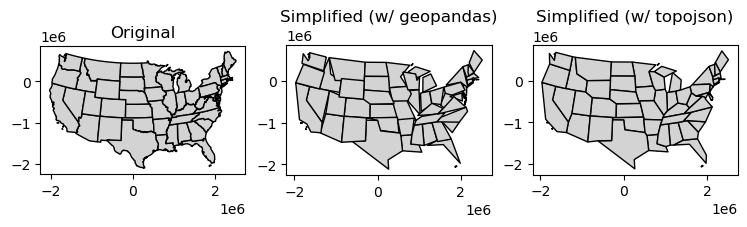

In [12]:
#| label: fig-simplify-polygons
#| fig-cap: Polygon simplification in action, comparing the original geometry of the contiguous United States with simplified versions, generated with functions from the geopandas (middle), and topojson (right), packages. 

fig, axes = plt.subplots(ncols=3, figsize=(9,5))
us_states2163.plot(ax=axes[0], color='lightgrey', edgecolor='black')
us_states_simp1.plot(ax=axes[1], color='lightgrey', edgecolor='black')
us_states_simp2.plot(ax=axes[2], color='lightgrey', edgecolor='black')
axes[0].set_title("Original")
axes[1].set_title("Simplified (w/ geopandas)")
axes[2].set_title("Simplified (w/ topojson)");

### 形心

质心运算确定地理对象的中心。 与集中趋势的统计度量（包括“平均值”的平均值和中位数定义）一样，定义对象的地理中心的方法有很多。 它们都创建了更复杂的矢量对象的单点表示。

最常用的质心运算是地理质心。 这种类型的质心操作（通常称为“质心”）代表空间对象的质心（想象一下平衡手指上的盘子）。 地理质心有很多用途，例如创建复杂几何形状的简单点表示，或估计多边形之间的距离。 “GeoSeries”或“GeoDataFrame”中几何图形的质心可通过“.centroid”属性访问，如下面的代码所示，它生成新西兰地区和塞纳河支流的地理质心，如下所示 @fig-centroid-pnt-on-surface 中的黑点。

In [13]:
nz_centroid = nz.centroid
seine_centroid = seine.centroid

有时，地理质心落在其父对象的边界之外（想想甜甜圈）。 在这种情况下，可以使用表面上的点操作来保证该点位于父对象中（例如，用于标记不规则的多边形对象，例如岛屿国家），如 @fig-centroid-pnt-on- 中的红点所示 表面。 请注意，这些红点始终位于其父对象上。 它们是使用“representative_point”方法创建的，如下所示：

In [14]:
nz_pos = nz.representative_point()
seine_pos = seine.representative_point()

表面上的质心和点在 @fig-centroid-pnt-on-surface 中说明：

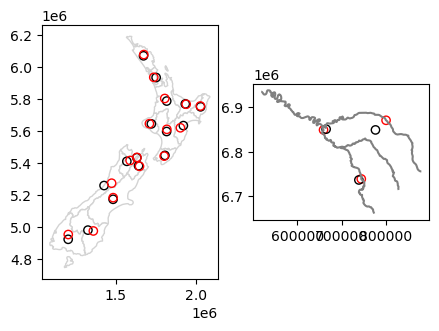

In [15]:
#| label: fig-centroid-pnt-on-surface
#| fig-cap: Centroids (black) and points on surface red of New Zealand and Seine datasets.

fig, axes = plt.subplots(ncols=2)
nz.plot(ax=axes[0], color="white", edgecolor="lightgrey")
nz_centroid.plot(ax=axes[0], color="None", edgecolor="black")
nz_pos.plot(ax=axes[0], color="None", edgecolor="red")
seine.plot(ax=axes[1], color="grey")
seine_pos.plot(ax=axes[1], color="None", edgecolor="red")
seine_centroid.plot(ax=axes[1], color="None", edgecolor="black");

### 缓冲器

缓冲区是表示几何特征给定距离内区域的多边形：无论输入是点、线还是多边形，输出都是多边形。 与简化（通常用于可视化和减小文件大小）不同，缓冲往往用于地理数据分析。 这条线的给定距离内有多少个点？ 哪些人群在这家新店的出行范围内？ 可以通过在感兴趣的地理实体周围创建缓冲区来回答和可视化此类问题。

@fig-buffers 展示了塞纳河及其支流周围不同大小的缓冲区（5 公里和 50 公里）。 这些缓冲区是使用下面的命令创建的，这些命令表明应用于“GeoSeries”（或“GeoDataFrame”）的“.buffer”方法需要一个重要参数：缓冲区距离，以 CRS 的单位提供（在本例中） 米）：

In [16]:
seine_buff_5km = seine.buffer(5000)
seine_buff_50km = seine.buffer(50000)

5 公里和 50 公里缓冲区在 @fig-buffers 中可视化：

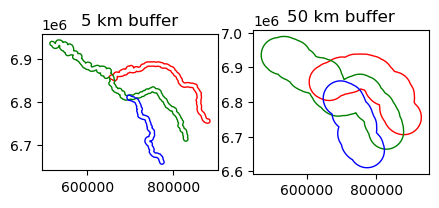

In [17]:
#| label: fig-buffers
#| fig-cap: Buffers around the Seine dataset of 5 km (left) and 50 km (right). Note the colors, which reflect the fact that one buffer is created per geometry feature.

fig, axes = plt.subplots(ncols=2)
seine_buff_5km.plot(ax=axes[0], color="none", edgecolor=["red", "green", "blue"])
seine_buff_50km.plot(ax=axes[1], color="none", edgecolor=["red", "green", "blue"])
axes[0].set_title("5 km buffer")
axes[1].set_title("50 km buffer");

请注意，即使输入是“GeoDataFrame”，“.centroid”和“.buffer”都会返回“GeoSeries”对象：

In [18]:
seine_buff_5km

0    POLYGON ((657550.332 6852587.97...
1    POLYGON ((517151.801 6930724.10...
2    POLYGON ((701519.740 6813075.49...
dtype: geometry

在常见情况下，当需要保留输入要素的原始属性时，您可以用新的“GeoSeries”替换现有几何图形，如下所示：

In [19]:
seine_buff_5km = seine.copy()
seine_buff_5km['geometry'] = seine.buffer(5000)
seine_buff_5km

,name,geometry
0,Marne,POLYGON ((657550.332 6852587.97...
1,Seine,POLYGON ((517151.801 6930724.10...
2,Yonne,POLYGON ((701519.740 6813075.49...


### 仿射变换

仿射变换是任何保留直线和平行性的变换。 然而，角度或长度不一定被保留。 仿射变换包括平移（平移）、缩放和旋转等。 另外，可以使用这些的任意组合。 仿射变换是地理计算的重要组成部分。 例如，标签放置需要移动，在非连续区域制图图中使用缩放，并且在重新投影或改进基于扭曲或错误投影的地图创建的几何图形时应用许多仿射变换。

“geopandas”包为“GeoSeries”和“GeoDataFrame”类的对象实现仿射变换。 在这两种情况下，该方法都应用于“GeoSeries”部分，返回转换几何图形的新“GeoSeries”。

“GeoSeries”的仿射变换可以使用“.affine_transform”方法来完成，该方法是“shapely.affinity.affine_transform”函数的包装器。 根据[文档](https://shapely.readthedocs.io/en/stable/manual.html#shapely.affinity.affine_transform)，2D仿射变换需要一个六参数列表`[a,b,d, e,xoff,yoff]` 表示以下坐标变换方程：

$$
x' = a x + b y + x_\mathrm{off}
$$

$$
y' = d x + e y + y_\mathrm{off}
$$

对于特定场景，还有简化的“GeoSeries”[方法](https://geopandas.org/en/stable/docs/user_guide/geometric_manipulations.html#affine-transformations)：

* `GeoSeries.translate(xoff=0.0, yoff=0.0, zoff=0.0)`
* `GeoSeries.scale(xfact=1.0, yfact=1.0, zfact=1.0, origin='center')`
* `GeoSeries.rotate(角度, origin='center', use_radians=False)`
* `GeoSeries.skew(角度, origin='center', use_radians=False)`

例如，*shifting* 仅需要 $x_{off}$ 和 $y_{off}$，使用 `.translate`。 下面的代码将 y 坐标向北移动 100,000 米，但保持 x 坐标不变：

In [20]:
nz_shift = nz.translate(0, 100000)

缩放将对象放大或缩小一个因子。 它可以在全球或本地应用。 全局缩放会增加或减少相对于原点坐标的所有坐标值，同时保持所有几何拓扑关系完整。

`Geopandas` 使用 `.scale` 方法实现局部缩放。 局部缩放独立地处理几何图形，并且需要围绕几何图形进行缩放的点，例如质心。 在下面的示例中，每个几何体围绕质心（@fig-affine-transformations 中的中间面板）缩小了两倍。 为了实现这一点，我们传递“0.5”和“0.5”缩放因子（分别针对 x 和 y），以及原点的“质心”选项。 （除了“centroid”之外，还可以使用“center”作为边界框中心或特定点坐标。）

In [21]:
nz_scale = nz.scale(0.5, 0.5, origin="centroid")

可以使用“.rotate”方法来旋转几何图形。 旋转时，我们需要指定旋转角度（正值表示顺时针旋转）和“原点”点（使用与“scale”中相同的选项）。 例如，以下表达式围绕几何质心逆时针旋转 nz 30 度：

In [22]:
nz_rotate = nz.rotate(-30, origin="centroid")

@fig-affine-transformations 显示原始层“nz”，以及移位、缩放和旋转结果。

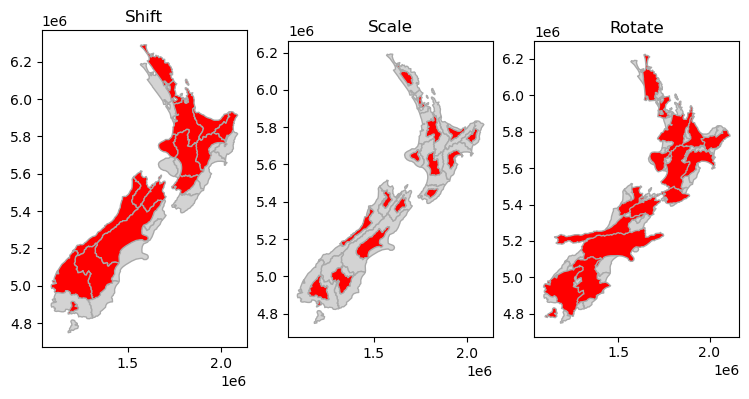

In [23]:
#| label: fig-affine-transformations
#| fig-cap: "Illustrations of affine transformations: shift, scale and rotate."

fig, axes = plt.subplots(ncols=3, figsize=(9,5))
nz.plot(ax=axes[0], color="lightgrey", edgecolor="darkgrey")
nz_shift.plot(ax=axes[0], color="red", edgecolor="darkgrey")
nz.plot(ax=axes[1], color="lightgrey", edgecolor="darkgrey")
nz_scale.plot(ax=axes[1], color="red", edgecolor="darkgrey")
nz.plot(ax=axes[2], color="lightgrey", edgecolor="darkgrey")
nz_rotate.plot(ax=axes[2], color="red", edgecolor="darkgrey")
axes[0].set_title("Shift")
axes[1].set_title("Scale")
axes[2].set_title("Rotate");

### 裁剪

空间裁剪是空间子集化的一种形式，涉及对至少一些受影响要素的几何列的更改。

剪裁只能应用于比点更复杂的特征：线、多边形及其“多重”等价物。 为了说明这个概念，我们将从一个简单的例子开始：两个重叠的圆，其中心点彼此相距一个单位，半径为一（@fig-overlapping-circles）。

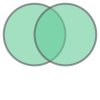

In [24]:
#| label: fig-overlapping-circles
#| fig-cap: Overlapping circles.

x = shapely.geometry.Point((0, 0)).buffer(1)
y = shapely.geometry.Point((1, 0)).buffer(1)
shapely.geometry.GeometryCollection([x, y])

想象一下，您不想选择一个圆或另一个圆，而是选择 x 和 y 覆盖的空间。 这可以使用“shapely”中的“.intersection”方法来完成，使用代表左侧和右侧圆圈的名为“x”和“y”的对象进行说明（@fig-intersection）。

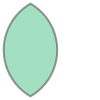

In [25]:
#| label: fig-intersection
#| fig-cap: Overlapping circles with a gray color indicating intersection between them. 

x.intersection(y)

### 子集化和裁剪
剪切对象可以更改其几何形状，但也可以对对象进行子集化，仅返回与剪切/子集化对象相交（或部分相交）的要素。
为了说明这一点，我们将在 @fig-overlapping-circles 中对覆盖圆 x 和 y 的边界框的点进行子集化。
有些点只在一个圆内，有些点在两个圆内，有些点都不在两个圆内。
以下代码部分在圆 x 和 y 的范围内生成点的简单随机分布，从而产生 @fig-random-points 中所示的输出。
我们分两步进行。 首先，我们找出要生成随机点的边界：

In [60]:
bounds = x.union(y).bounds
bounds

(-1.0, -1.0, 2.0, 1.0)

其次，我们使用 np.random.uniform 计算给定范围内的 n 个随机 x 和 y 坐标：

In [61]:
np.random.seed(1)
n = 10  ## Number of points to generate
coords_x = np.random.uniform(bounds[0], bounds[2], n)
coords_y = np.random.uniform(bounds[1], bounds[3], n)
coords = list(zip(coords_x, coords_y))
coords

[(0.2510660141077219, -0.1616109711934104),
 (1.1609734803264744, 0.370439000793519),
 (-0.9996568755479653, -0.5910955005369651),
 (-0.0930022821044807, 0.7562348727818908),
 (-0.5597323275486609, -0.9452248136041477),
 (-0.7229842156936066, 0.34093502035680445),
 (-0.4412193658669873, -0.16539039526574606),
 (0.03668218112914312, 0.11737965689150331),
 (0.1903024226920098, -0.7192261228095325),
 (0.6164502020100708, -0.6037970218302424)]

第三，我们将坐标列表转换为“shapely”点的“列表”：

In [62]:
pnt = [shapely.geometry.Point(i) for i in coords]
pnt

[<POINT (0.251 -0.162)>,
 <POINT (1.161 0.37)>,
 <POINT (-1 -0.591)>,
 <POINT (-0.093 0.756)>,
 <POINT (-0.56 -0.945)>,
 <POINT (-0.723 0.341)>,
 <POINT (-0.441 -0.165)>,
 <POINT (0.037 0.117)>,
 <POINT (0.19 -0.719)>,
 <POINT (0.616 -0.604)>]

然后到`GeoSeries`：

In [63]:
pnt = gpd.GeoSeries(pnt)
pnt

0     POINT (0.25107 -0.16161)
1      POINT (1.16097 0.37044)
2    POINT (-0.99966 -0.59110)
               ...            
7      POINT (0.03668 0.11738)
8     POINT (0.19030 -0.71923)
9     POINT (0.61645 -0.60380)
Length: 10, dtype: geometry

结果显示在@fig-random-points中：

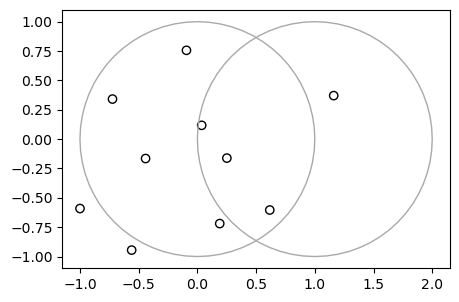

In [64]:
#| label: fig-random-points
#| fig-cap: Randomly distributed points within the bounding box enclosing circles x and y. The point that intersects with both objects x and y are highlighted. 

base = pnt.plot(color='none', edgecolor='black')
gpd.GeoSeries([x]).plot(ax=base, color='none', edgecolor='darkgrey');
gpd.GeoSeries([y]).plot(ax=base, color='none', edgecolor='darkgrey');

现在，我们回到我们的问题：如何对点进行子集化以仅返回与 x 和 y 相交的点？
下面的代码块演示了实现相同结果的三种方法。
我们可以计算一个布尔值“Series”，评估“pnt”的每个点是否与 x 和 y 的交集相交：

In [65]:
sel = pnt.intersects(x.intersection(y))
sel

0     True
1    False
2    False
     ...  
7     True
8    False
9     True
Length: 10, dtype: bool

然后使用它对`pnt`进行子集化以获得结果`pnt1`：

In [66]:
pnt1 = pnt[sel]
pnt1

0    POINT (0.25107 -0.16161)
7     POINT (0.03668 0.11738)
9    POINT (0.61645 -0.60380)
dtype: geometry

我们还可以使用“x”和“y”的交集作为子集/裁剪对象来找到由“pnt”表示的输入点之间的交集。 由于第二个参数是一个单独的“shapely”几何体（“x.intersection(y)”），我们得到每个“pnt”与其的“成对”交集：

In [67]:
pnt2 = pnt.intersection(x.intersection(y))
pnt2

0    POINT (0.25107 -0.16161)
1                 POINT EMPTY
2                 POINT EMPTY
               ...           
7     POINT (0.03668 0.11738)
8                 POINT EMPTY
9    POINT (0.61645 -0.60380)
Length: 10, dtype: geometry

结果显示在@fig-intersection-points中：

<Axes: >

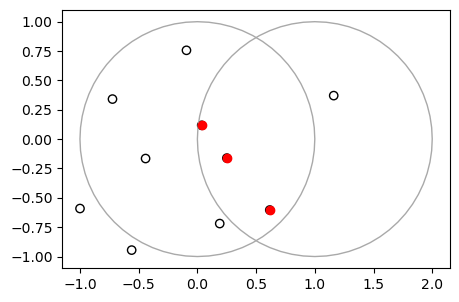

In [68]:
#| label: fig-intersection-points
#| fig-cap: Randomly distributed points within the bounding box enclosing circles x and y. The point that intersects with both objects x and y are highlighted. 

base = pnt.plot(color='none', edgecolor='black')
gpd.GeoSeries([x]).plot(ax=base, color='none', edgecolor='darkgrey');
gpd.GeoSeries([y]).plot(ax=base, color='none', edgecolor='darkgrey');
pnt2.plot(ax=base, color='red')

可以过滤掉空几何图形以保留所需的子集，并获得与“pnt1”相同的“pnt2”：

In [69]:
pnt2 = pnt2[~pnt2.is_empty]  ## Subset non-empty geometries
pnt2

0    POINT (0.25107 -0.16161)
7     POINT (0.03668 0.11738)
9    POINT (0.61645 -0.60380)
dtype: geometry

第二种方法将返回与“x.intersection(y)”部分相交的要素，但对跨越子集对象边界的空间广泛要素进行了修改的几何形状。 结果是相同的，但实现却有很大不同。

尽管上面的示例是出于教育而非应用目的而设计的，并且我们鼓励读者重现结果以加深您对 R 中处理地理矢量对象的理解，但它提出了一个重要的问题：使用哪种实现？ 一般来说，更简洁的实现应该受到青睐，这意味着上面的第一种方法。 我们将在第 11 章中回到在相同技术或算法的不同实现之间进行选择的问题。


### 几何并集

正如我们在@sec-vector-attribute-aggregation 中看到的，空间聚合可以默默地溶解同一组中接触多边形的几何形状。 下面的代码块对此进行了演示，其中使用 .dissolve 方法将 49 个“us_states”聚合为 4 个区域：

In [26]:
regions = us_states.dissolve(by='REGION', aggfunc='sum').reset_index()
regions

,REGION,geometry,GEOID,...,AREA,total_pop_10,total_pop_15
0,Midwest,MULTIPOLYGON (((-89.10077 36.94...,182027293846171926313955,...,1.984047e+06,66514091.0,67546398.0
1,Norteast,MULTIPOLYGON (((-75.61724 39.83...,092534364250233344,...,4.357609e+05,54909218.0,55989520.0
2,South,MULTIPOLYGON (((-81.38550 30.27...,0112132240454854051011212428374751,...,2.314087e+06,112072990.0,118575377.0
3,West,MULTIPOLYGON (((-118.36998 32.8...,0408163032063541495356,...,3.073145e+06,68444193.0,72264052.0


结果显示在@fig-dissolve中：

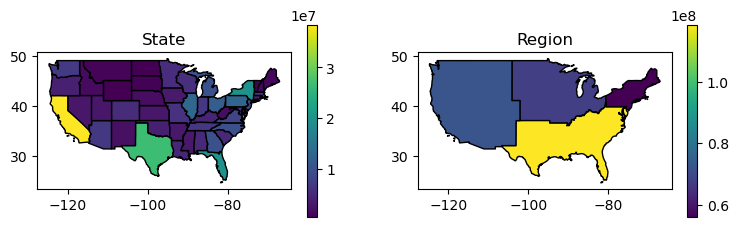

In [27]:
#| label: fig-dissolve
#| fig-cap: "Spatial aggregation on contiguous polygons, illustrated by aggregating the population of US states into regions, with population represented by color. Note the operation automatically dissolves boundaries between states."

fig, axes = plt.subplots(ncols=2, figsize=(9, 2.5))
us_states.plot(ax=axes[0], edgecolor='black', column='total_pop_15', legend=True)
regions.plot(ax=axes[1], edgecolor='black', column='total_pop_15', legend=True)
axes[0].set_title('State')
axes[1].set_title('Region');

几何方面发生了什么？ 在幕后，“.dissolve”组合几何图形并使用 [`.unary_union`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.unary_union.html#geopandas.GeoSeries.unary_union) 方法消除它们之间的边界。 下面的代码块演示了这一点，该代码块使用独立的“unary_union”操作创建了一个统一的美国西部：

In [28]:
us_west = us_states[us_states['REGION'] == 'West']
us_west_union = us_west['geometry'].unary_union

请注意，结果是“匀称”几何体，因为各个属性在溶解过程中“丢失”。 结果显示在@fig-dissolve2中。

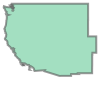

In [29]:
#| label: fig-dissolve2
#| fig-cap: Western US

us_west_union

要将两组（或多组）“GeoDataFrame”分解为一个几何图形，我们可以使用组合条件：

In [30]:
sel = (us_states['REGION'] == 'West') | (us_states['NAME'] == 'Texas')
texas_union = us_states[sel]
texas_union = texas_union['geometry'].unary_union

或连接两个单独的子集：

In [31]:
us_west = us_states[us_states['REGION'] == 'West']
texas = us_states[us_states['NAME'] == 'Texas']
texas_union = pd.concat([us_west, texas]).unary_union

然后使用`.unary_union`溶解。 两种情况的结果是相同的，如 @fig-dissolve 3 所示。

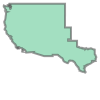

In [32]:
#| label: fig-dissolve3
#| fig-cap: Western US and Texas

texas_union

### 类型转换

通常需要将几何形状从一种类型转换为另一种类型，也称为“几何铸造”，以促进空间分析。 `shapely` 包可用于几何铸造。 确切的表达式取决于我们感兴趣的特定转换。一般来说，您需要根据“目标”几何图形（例如“shapely.geometry.LineString”， 等），然后将“源”几何体的输入重新整形为要传递给该函数的正确形式。

让我们创建一个“MultiPoint”来说明几何铸造如何在“shapely”几何对象上工作：

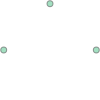

In [33]:
multipoint = shapely.geometry.MultiPoint([(1,1), (3,3), (5,1)])
multipoint

可以使用点“列表”中的“shapely.geometry.LineString”创建“LineString”。 因此，通过将各个点提取到“列表”中，然后将它们传递给“shapely.geometry.LineString”，可以将“MultiPoint”转换为“LineString”：

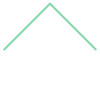

In [34]:
linestring = shapely.geometry.LineString(list(multipoint.geoms))
linestring

还可以使用函数“shapely.geometry.Polygon”创建“多边形”，该函数接受一系列点坐标。 原则上，最后一个坐标必须等于第一个坐标，才能形成闭合形状。 然而，“shapely.geometry.Polygon”能够自动完成最后一个坐标。 所以：

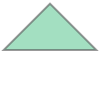

In [35]:
polygon = shapely.geometry.Polygon([[p.x, p.y] for p in multipoint.geoms])
polygon

源“MultiPoint”几何图形以及派生的“LineString”和“Polygon”几何图形显示在@fig-casting1中。 请注意，我们将“shapely”几何图形转换为“GeoSeries”，以便更轻松地进行多面板绘图：

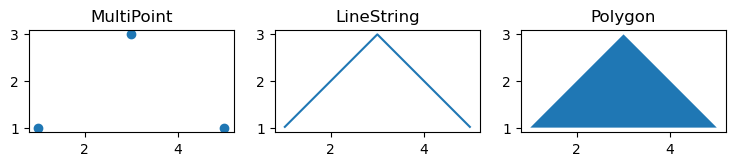

In [36]:
#| label: fig-casting1
#| fig-cap: Examples of linestring and polygon casted from a multipoint geometry.

fig, axes = plt.subplots(ncols=3, figsize=(9,5))
gpd.GeoSeries(multipoint).plot(ax=axes[0])
gpd.GeoSeries(linestring).plot(ax=axes[1])
gpd.GeoSeries(polygon).plot(ax=axes[2])
axes[0].set_title("MultiPoint")
axes[1].set_title("LineString")
axes[2].set_title("Polygon");

从多点到线串的转换是一种常见操作，它根据有序点观测（例如 GPS 测量或地理标记媒体）创建线对象。 这允许空间操作，例如行进路径的长度。 从多点或线串到多边形的转换通常用于计算面积，例如根据在湖泊周围或从建筑物角落进行的 GPS 测量集来计算面积。

我们的“LineString”几何体可以通过将其坐标直接传递给“shapely.geometry.MultiPoint”来将其转换为“MultiPoint”几何体：

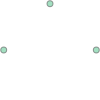

In [37]:
# 'LineString' -> 'MultiPoint'
shapely.geometry.MultiPoint(linestring.coords)

“Polygon”（外部）坐标也可以传递给“shapely.geometry.MultiPoint”：

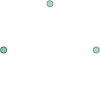

In [38]:
# 'Polygon' -> 'MultiPoint'
shapely.geometry.MultiPoint(polygon.exterior.coords)


## Geometric operations on raster data 

### 聚合和分解
栅格数据集因其分辨率而异，从能够看到单个树木的高分辨率数据集到覆盖整个地球的低分辨率数据集。
由于多种原因，可以将栅格数据集转换为降低（聚合）或提高（分解）其分辨率。
聚合可以减少栅格存储和后续步骤的计算资源需求，分解可用于匹配其他数据集或添加细节。
例如，我们在这里将“dem.tif”的空间分辨率更改为 5 倍（图@fig-raster-aggregate）。

事实上，栅格聚合是栅格重采样的一种特殊情况（请参阅@sec-raster-resampling），其中目标栅格网格与原始栅格对齐，仅使用较粗糙的像素。 栅格重采样是一般情况，其中新网格不一定是原始网格的聚合，也可以是任何其他情况（例如旋转和/或移位网格等）。

要使用“rasterio”聚合栅格，我们需要执行[两个步骤](https://rasterio.readthedocs.io/en/stable/topics/resampling.html)：

* 将栅格值（使用“.read”）读取到与原始“.shape”不同的“out_shape”中
* 根据`out_shape`更新`transform`

我们来演示一下。 首先，我们使用“rasterio.open”创建到“dem.tif”的文件连接：




In [39]:
src = rasterio.open('data/dem.tif')

注意栅格的形状，它有 117 行和 117 列：

In [40]:
src.read(1).shape

(117, 117)

另请注意“变换”，它告诉我们光栅分辨率为 30.85 $m$：

In [41]:
src.transform

Affine(30.849999999999604, 0.0, 794599.1076146346,
       0.0, -30.84999999999363, 8935384.324602526)

现在，我们可以指定“out_shape”将值读取为不同的形状，而不是像“src.read(1)”中那样以通常的方式读取栅格值。
在这里，我们计算一个新的形状，该形状缩小了“5”倍，即行数和列数乘以“0.2”。
我们必须截断任何“部分”行和列，例如使用“int”。
现在从 $\sim 5 \times 5 = \sim 25$“旧”栅格值获取或“重新采样”每个新像素。
我们可以通过“resampling”参数选择重采样方法。
这里我们使用“rasterio.enums.Resampling.average”，即新的“大”像素值是所有重合小像素的平均值，这对于“dem.tif”中的高程数据有意义：


In [42]:
factor = 0.2
r = src.read(1,
    out_shape=(
        int(src.height * factor),
        int(src.width * factor)
        ),
    resampling=rasterio.enums.Resampling.average
)

生成的数组“r”具有较小的“.shape”，如下所示：

In [43]:
r.shape

(23, 23)

其他有用的选项包括：

* `rasterio.enums.Resampling.nearest`---最近邻重采样
* `rasterio.enums.Resampling.bilinear`---双线性重采样
* `rasterio.enums.Resampling.cubic`---三次重采样
* `rasterio.enums.Resampling.lanczos`---Lanczos窗口重采样
* `rasterio.enums.Resampling.mode`---模式重采样（最常见的值）
* `rasterio.enums.Resampling.min`---最小重采样
* `rasterio.enums.Resampling.max`---最大重采样
* `rasterio.enums.Resampling.med`---中值重采样
* `rasterio.enums.Resampling.sum`---中值重采样

有关这些方法的说明，请参阅下文 (@sec-raster-resampling)。

第二步是更新“变换”，考虑光栅形状的变化，如下所示：

In [44]:
new_transform = src.transform * src.transform.scale(
    (src.width / r.shape[0]),
    (src.height / r.shape[1])
)
new_transform

Affine(156.93260869565017, 0.0, 794599.1076146346,
       0.0, -156.9326086956198, 8935384.324602526)

原始栅格和聚合栅格显示在 @fig-raster-aggregate 中：

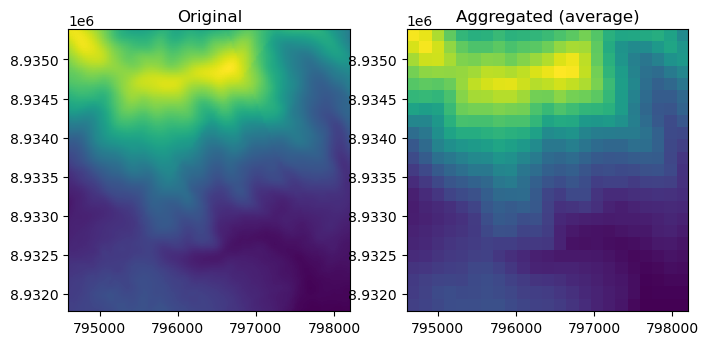

In [45]:
#| label: fig-raster-aggregate
#| fig-cap: Original raster (left), and aggregated raster (right). 

fig, axes = plt.subplots(ncols=2, figsize=(8,4))
rasterio.plot.show(src, ax=axes[0])
rasterio.plot.show(r, transform=new_transform, ax=axes[1])
axes[0].set_title('Original')
axes[1].set_title('Aggregated (average)');

如果我们需要导出新栅格，我们需要更新元数据：

In [46]:
dst_kwargs = src.meta.copy()
dst_kwargs.update({
    'transform': new_transform,
    'width': r.shape[0],
    'height': r.shape[1],
})
dst_kwargs

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': nan,
 'width': 23,
 'height': 23,
 'count': 1,
 'crs': CRS.from_epsg(32717),
 'transform': Affine(156.93260869565017, 0.0, 794599.1076146346,
        0.0, -156.9326086956198, 8935384.324602526)}

然后以写入模式创建一个新文件，并将“r”中的值写入该文件（请参阅@sec-data-output-raster）：

In [47]:
dst = rasterio.open('output/dem_agg5.tif', 'w', **dst_kwargs)
dst.write(r, 1)
dst.close()

相反的操作，分解，是当我们增加栅格对象的分辨率时。 可以使用任一受支持的重采样方法（参见上文）。 然而，由于我们实际上并不是在总结信息，而是将一个大像素的值转换为多个小像素，因此使用以下任一方法都是有意义的：

* 最近邻重采样（`rasterio.enums.Resampling.nearest`），当想要保持原始值不变时，因为修改它们将是不正确的（例如在分类栅格中）
*当我们希望较小的像素反映原始值之间的逐渐变化时，例如当分解的栅格用于可视化目的时，平滑技术，例如双线性重采样（`rasterio.enums.Resampling.bilinear`）

为了分解栅格，我们采用与聚合相同的工作流程，只是使用不同的因子，例如“factor=5”而不是“factor=0.2”，即*增加*栅格像素的数量而不是减少。 在此示例中，我们使用双线性插值来获得平滑的高分辨率栅格：


In [48]:
factor = 5
r2 = src.read(1,
    out_shape=(
        int(src.height * factor),
        int(src.width * factor)
        ),
    resampling=rasterio.enums.Resampling.bilinear
)


这是分解栅格的大小：

In [49]:
r2.shape

(585, 585)

这里是与聚合所示相同的表达式，用于计算新的变换：

In [50]:
new_transform2 = src.transform * src.transform.scale(
    (src.width / r2.shape[0]),
    (src.height / r2.shape[1])
)
new_transform2

Affine(6.169999999999921, 0.0, 794599.1076146346,
       0.0, -6.169999999998726, 8935384.324602526)

原始栅格和分解栅格左上角的放大显示在 @fig-raster-disaggregate 中：


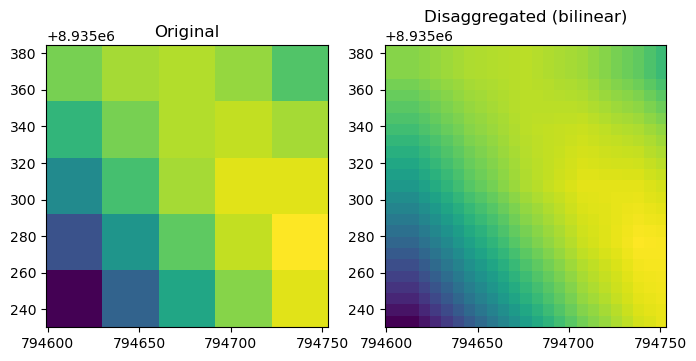

In [51]:
#| label: fig-raster-disaggregate
#| fig-cap: Original raster (left), and disaggregated raster (right). The same top-left corner extent of both rasters is shown, to zoom-in and demonstrate the effect of bilinear interpolation.

fig, axes = plt.subplots(ncols=2, figsize=(8,4))
rasterio.plot.show(src.read(1)[:5, :5], transform=src.transform, ax=axes[0])
rasterio.plot.show(r2[:25, :25], transform=new_transform2, ax=axes[1])
axes[0].set_title('Original')
axes[1].set_title('Disaggregated (bilinear)');

导出分解栅格的代码与上面用于聚合栅格的代码相同，因此省略它以节省空间。

### 重新采样 {#sec-raster-resampling}

上述聚合和分解方法仅适用于当我们想要通过聚合/分解因子更改栅格的分辨率时。
但是，当我们有两个或多个具有不同分辨率和来源的栅格时该怎么办？
这就是重采样的作用——计算新像素位置值的过程。
简而言之，此过程采用原始栅格的值，并使用自定义分辨率和原点（@fig-raster-resample）重新计算目标栅格的新值。

有多种方法可以估计具有不同分辨率/原点的栅格的值（@fig-raster-resample）。 主要的重采样方法包括：

* 最近邻：将原始栅格的最近像元的值分配给目标栅格的像元。 这是一种快速简单的技术，通常适用于对分类栅格进行重采样。
* 双线性插值：将原始栅格中四个最近像元的加权平均值分配给目标栅格的像元。 这是适用于连续栅格的最快方法。
* 三次插值：使用原始栅格的 16 个最近像元的值，应用三阶多项式函数来确定输出像元值。 用于连续栅格，与双线性插值相比，会产生更平滑的表面，但计算要求更高。
* 三次样条插值：也使用原始栅格的 16 个最近像元的值来确定输出像元值，但应用三次样条（分段三阶多项式函数）。 用于连续栅格。
* Lanczos 加窗正弦重采样：使用原始栅格的 36 个最近像元的值来确定输出像元值。 用于连续栅格。
* 此外，我们可以使用简单的汇总方法，考虑与目标像素重合的所有像素，例如平均值（@fig-raster-aggregate）、最小值、最大值（@fig-raster-resample）、中值、众数、 和总和。

上述解释强调，只有最近邻重采样适合分类栅格，而所有其余方法都可用于连续栅格（具有不同的结果）。

使用“rasterio”，可以使用函数“rasterio.warp.reproject”完成重采样。
再次注意，栅格重投影与重采样并没有本质上的不同，区别只是目标网格是与原点位于相同的 CRS 中（重采样）还是位于不同的 CRS 中（重投影）。
换句话说，重投影是“重采样”到不同 CRS 中的网格中。 稍后我们将使用“rasterio.warp.reproject”演示重投影（@sec-reprojecting-raster-geometries）。

无论我们是重新采样还是重新投影，“rasterio.warp.reproject”所需的信息是：

* 源和目标 *CRS*。 重新采样时这些可能相同，或者重新投影时不同。
* 源和目标*转换*

此外，“rasterio.warp.reproject”适用于文件连接，因此它需要以写入（“w”）模式连接到输出文件。 这使得该函数对于大型栅格非常有效。

目标和目的地 CRS 很容易指定，具体取决于我们的选择。 源转换也是可用的，例如，从源文件连接。
唯一复杂的部分是找出*目标变换*。
重采样时，变换通常源自*模板*栅格，例如我们希望原始栅格匹配的现有栅格文件，或者目标网格的数字规范（见下文）。
否则，当确切的网格不重要时，我们可以简单地聚合或分解栅格，如上所示（@sec-raster-agg-disagg）。
（请注意，重新投影时，目标变换并不容易计算出来，因此我们使用 `rasterio.warp.calculate_default_transform` 函数来计算它，如 @sec-reprojecting-raster-geometries 中所示。）

让我们演示重采样到通过数字约束（例如范围和分辨率）指定的目标网格：

In [52]:
xmin = 794650
xmax = 798250
ymin = 8931750 
ymax = 8935350
res = 300

变换是原点和分辨率的函数，可以使用“rasterio.transform.from_origin”函数创建，如下所示：


In [53]:
dst_transform = rasterio.transform.from_origin(west=xmin, north=ymax, xsize=res, ysize=res)
dst_transform

Affine(300.0, 0.0, 794650.0,
       0.0, -300.0, 8935350.0)

再次注意，如果我们需要重新采样到由现有“模板”栅格指定的网格中，我们可以跳过此步骤并简单地使用从该文件读取转换，如 `rasterio.open('template.tif') .变换`。

现在我们继续创建目标文件连接。
为此，我们还必须知道光栅尺寸。
这些可以从范围和分辨率中得出，如下所示：

In [54]:
width = int((xmax - xmin) / res)
height = int((ymax - ymin) / res)
width, height

(12, 12)

现在我们创建目标文件连接。
我们使用与源文件相同的元数据，除了尺寸和变换之外，它们将有所不同并反映重采样过程：

In [55]:
dst_kwargs = src.meta.copy()
dst_kwargs.update({
    'transform': dst_transform,
    'width': width,
    'height': height
})
dst = rasterio.open('output/dem_resample_nearest.tif', 'w', **dst_kwargs)

以下是我们如何使用函数“rasterio.warp.reproject”重新投影。 这里使用的重采样方法是最近邻重采样：

In [56]:
rasterio.warp.reproject(
    source=rasterio.band(src, 1),
    destination=rasterio.band(dst, 1),
    src_transform=src.transform,
    src_crs=src.crs,
    dst_transform=dst_transform,
    dst_crs=src.crs,
    resampling=rasterio.enums.Resampling.nearest
)

(Band(ds=<open DatasetWriter name='output/dem_resample_nearest.tif' mode='w'>, bidx=1, dtype='float32', shape=(12, 12)),
 Affine(300.0, 0.0, 794650.0,
        0.0, -300.0, 8935350.0))

最后，我们关闭文件：

In [57]:
dst.close()

这是另一个代码部分，用于演示另一种重采样方法，即最大重采样，即每个新像素都获得与其重合的所有原始像素的最大值。 请注意，变换是相同的（@fig-raster-resample），因此我们不需要再次计算它：


In [58]:
dst = rasterio.open('output/dem_resample_maximum.tif', 'w', **dst_kwargs)
rasterio.warp.reproject(
    source=rasterio.band(src, 1),
    destination=rasterio.band(dst, 1),
    src_transform=src.transform,
    src_crs=src.crs,
    dst_transform=dst_transform,
    dst_crs=src.crs,
    resampling=rasterio.enums.Resampling.max
)
dst.close()

原始栅格“dem.tif”以及两个重采样结果“dem_resample_nearest.tif”和“dem_resample_maximum.tif”显示在@fig-raster-resample中：


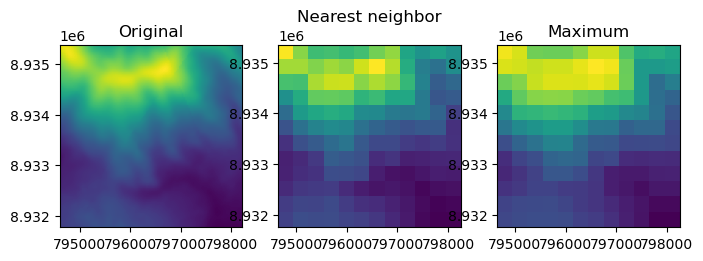

In [59]:
#| label: fig-raster-resample
#| fig-cap: 'Visual comparison of the original raster and two different resampling methods: nearest neighbor and maximum resampling.'

fig, axes = plt.subplots(ncols=3, figsize=(8,4))
rasterio.plot.show(src, ax=axes[0])
rasterio.plot.show(rasterio.open('output/dem_resample_nearest.tif'), ax=axes[1])
rasterio.plot.show(rasterio.open('output/dem_resample_maximum.tif'), ax=axes[2])
axes[0].set_title('Original')
axes[1].set_title('Nearest neighbor')
axes[2].set_title('Maximum');